# Fine-Tuning a BERT Encoder for Named Entity Recognition on CoNLL2003

Implemented for the NLP Cryptonite Research AI Taskphase by Pratham Shah - 240905614.

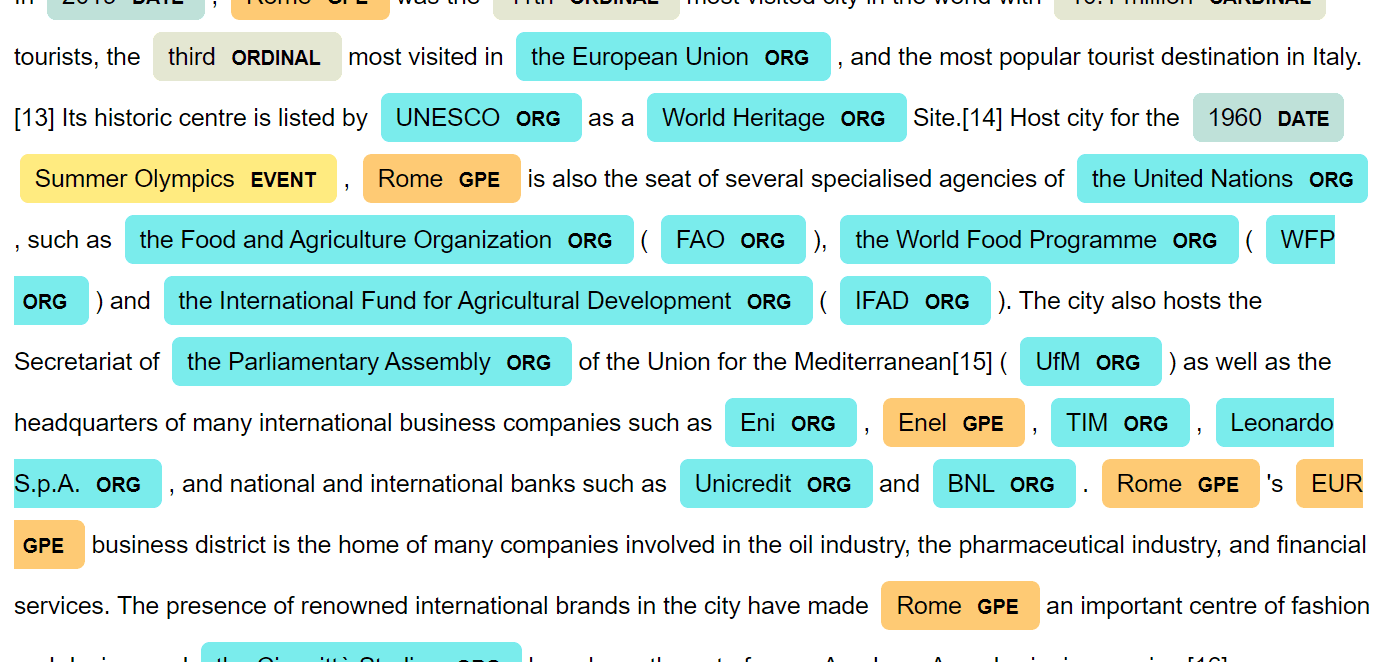
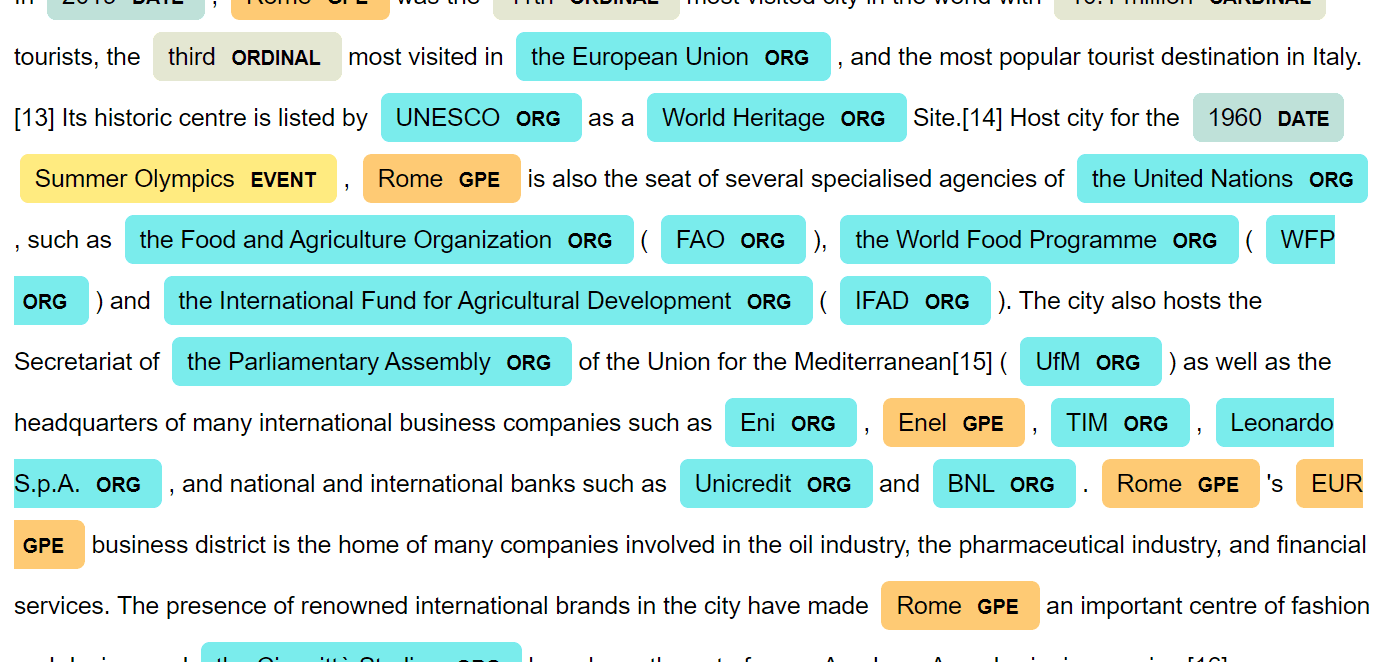

## Adding Imports

In [33]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

In [34]:
!pip install seqeval
from seqeval.metrics import classification_report

## Defining Labels

In [35]:
NER_labels = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"] #categories
label_id_map = {label: i for i, label in enumerate(NER_labels)} #tagging needs numerical 
id_label_map = {i: label for label, i in label_id_map.items()}

label_id_map

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

## Load CoNLL-2003 Data

A special formatting function is needed to process the raw data into acceptable sequence pairs for BERT.

In [36]:
def format(file_path):
    """
    Reads CoNLL2003 file and returns token and tag sequences
    
    Args:
        file_path: Path to the input file
        
    Returns:
        tokens: List of token sequences of sentences
        tags: List of corresponding tag sequences
        
    Sample:
        John NNP B-NP B-PER
        loves VBZ B-VP O
        New NNP B-NP B-LOC
        York NNP I-NP I-LOC

        He PRP B-NP O
        is VBZ B-VP O
        happy JJ B-ADJP O
        .
        
        is returned as
        
        [['John', 'loves', 'New', 'York'], ['He', 'is', 'happy', '.']]

        [[1, 0, 3, 4], [0, 0, 0, 0]]

    """
    
    tokens, tags = [], []
    current_tokens, current_tags = [], []

    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # empty line: save current sentence tokens and tags, then reset
            if not line:
                if current_tokens:  # only if current sentence is non-empty
                    #append found tokens and tags to the list
                    tokens.append(current_tokens)
                    tags.append(current_tags)
                    #reset here
                    current_tokens, current_tags = [], []
                continue

            word, pos, chunk, ner = line.split() #if a line is present, split it and add tokens and tags
            current_tokens.append(word)
            current_tags.append(label_id_map[ner])

    return tokens, tags

#formatting train, val and test
train_tokens, train_tags = format("/kaggle/input/conll003-englishversion/train.txt")
val_tokens, val_tags = format("/kaggle/input/conll003-englishversion/valid.txt")
test_tokens, test_tags = format("/kaggle/input/conll003-englishversion/test.txt")

## Tokenizer, Alignment and Model

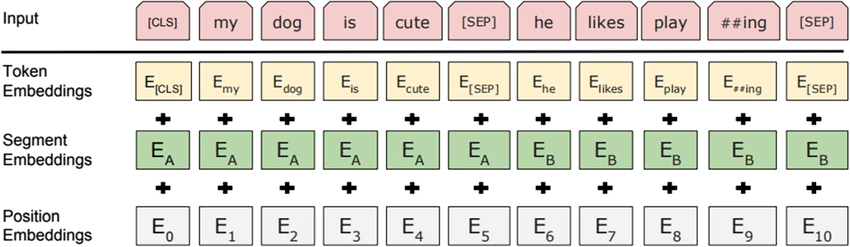

BERT tokenizer uses contextual and positional additions to embeddings.

This string defines the BERT model we'll use. For current speed and testing requirements, it has been set to BERT base, which ignores case in words ("uncased")

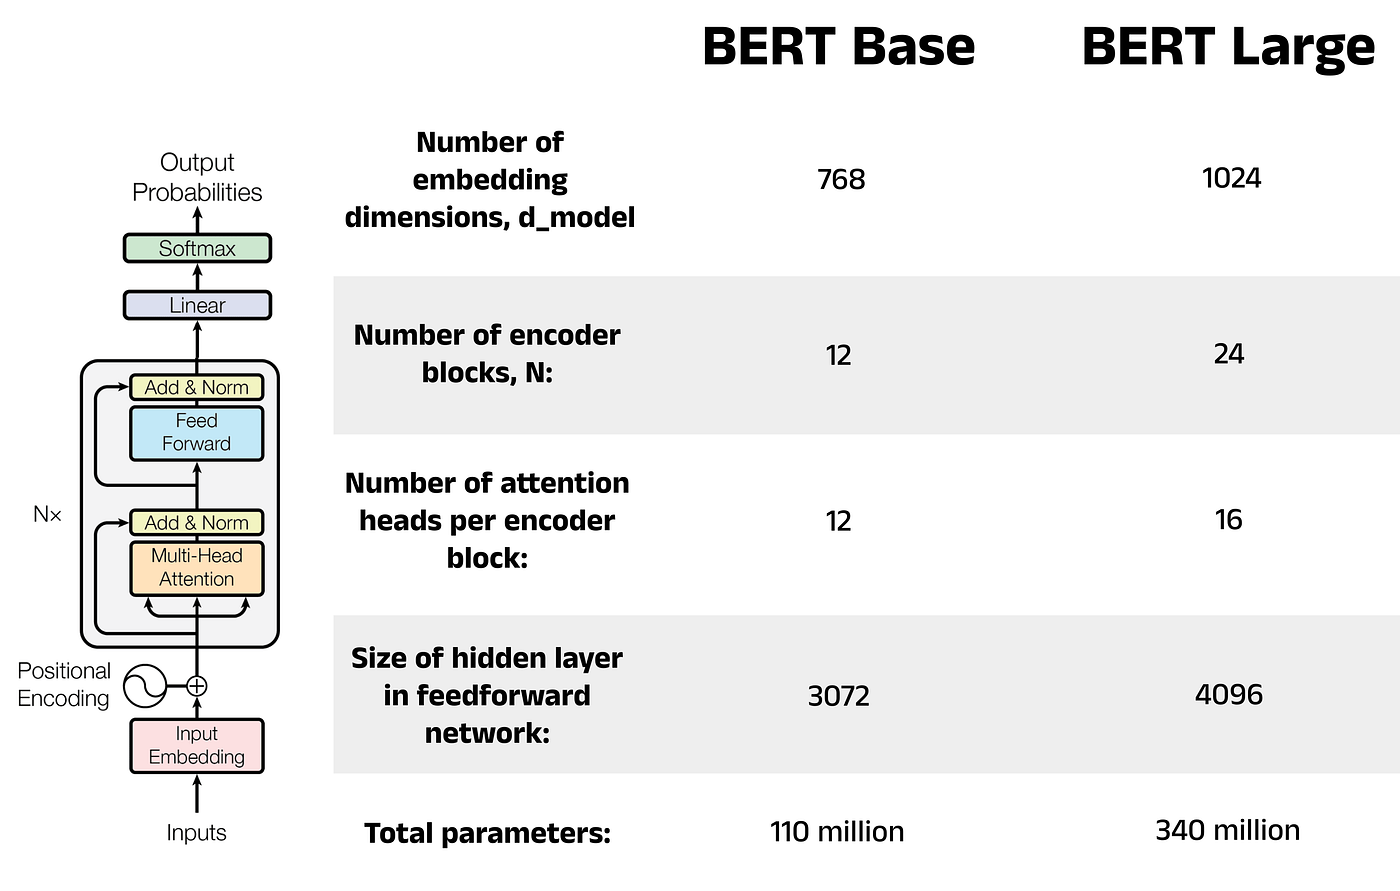
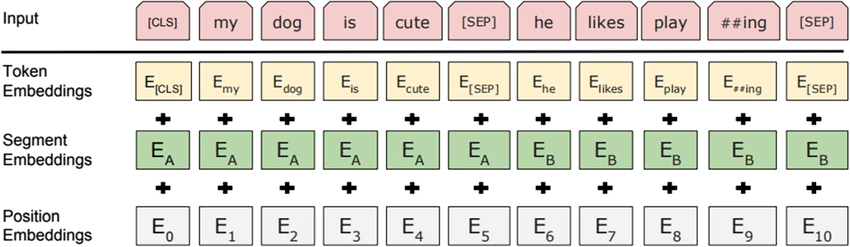
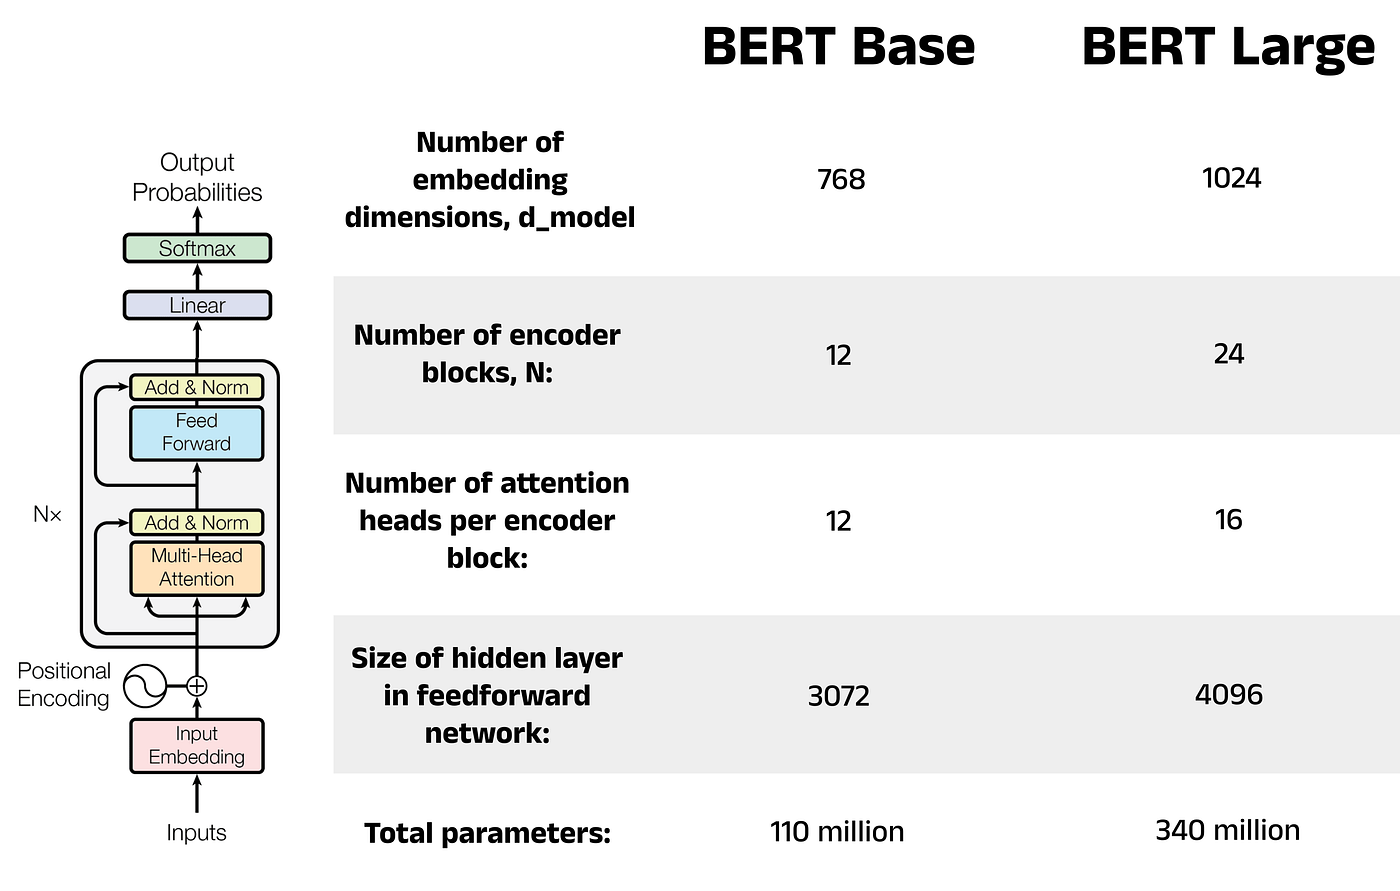

In [37]:
model = "bert-large-cased"

## Sample Example:

Take an unzipped example to be:
`tokens = ["visiting", "Mumbai"]`,
`labels = [0, 5]`  


The tokenizer breaks "visiting" into ["visit", "##ing"].

It then adds special tokens too:

[CLS], visit, ##ing, Mumbai, [SEP]

| Token index | Token     | word_idx from `word_ids()` | Label assigned            |
|-------------|-----------|------------------------------|---------------------------|
| 0           | `[CLS]`   | None                         | -1 (ignore)             |
| 1           | `visit`    | 0 (first word)               | 0    |
| 2           | `##ing`   | 0 (same first word)          | -1 (ignore subword)     |
| 3           | `Mumbai`| 1 (second word)              | 5                         |
| 4           | `[SEP]`   | None                         | -1                      |


In [38]:
tokenizer = AutoTokenizer.from_pretrained(model)

def tokenize_and_align_labels(tokens_list, tags_list, max_length=120):
    """
    Tokenizes sentences and aligns NER labels to wordpieces for model training.

    Args:
        tokens_list (list of list of str): List of sentences, each a list of words.
        tags_list (list of list of int): Corresponding NER tag IDs for each word.
        max_length (int): Max token length after tokenization.

    Returns:
        dict: Dictionary with input IDs, attention masks, and aligned labels.
        
    Sample Output:
        train_enc = {
            "input_ids": [[101, 123, 456, 102, 0, 0], [101, 789, 654, 102, 0, 0]],
            "attention_mask": [[1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0]],
            "labels": [[-1, 0, 2, -1, -1, -1], [-1, 1, 0, -1, -1, -1]]
        }
    """
    encodings = {"input_ids": [], "attention_mask": [], "labels": []}

    count = 0

    for tokens, labels in zip(tokens_list, tags_list):
        # tokenize a list of words keeping track of word boundaries
        tokenized = tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
        
        word_ids = tokenized.word_ids()  # maps each token piece back to the original word

        if count <= 10:
            print(tokenized.tokens())
            print(word_ids)
            print("\n")
            count += 1

        aligned_labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                # special tokens get label -1 to ignore in loss calculation
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                # for the first piece of a word use the actual label
                aligned_labels.append(labels[word_idx])
            else:
                # for the joined subwords use -1 to ignore in loss
                aligned_labels.append(-100)
            previous_word_idx = word_idx

        encodings["input_ids"].append(tokenized["input_ids"])
        # attention masking makes [PAD] 0, and other real tokens 1
        encodings["attention_mask"].append(tokenized["attention_mask"])
        encodings["labels"].append(aligned_labels)

    return encodings

#usage
train_enc = tokenize_and_align_labels(train_tokens, train_tags)
val_enc = tokenize_and_align_labels(val_tokens, val_tags)
test_enc = tokenize_and_align_labels(test_tokens, test_tags)

['[CLS]', '-', 'D', '##OC', '##ST', '##AR', '##T', '-', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

## NER Dataset creation

In [7]:
import torch
from torch.utils.data import Dataset

class DictDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        # return dictionary of tensors expected by huggingface trainer and collator
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

train_dataset = DictDataset(train_enc)
val_dataset = DictDataset(val_enc)
test_dataset = DictDataset(test_enc)

## Loading the Model

In [8]:
model = AutoModelForTokenClassification.from_pretrained(model, num_labels=len(NER_labels))
data_collator = DataCollatorForTokenClassification(tokenizer)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Function for Metrics Calculation

In [9]:
def compute_metrics(p):
    predictions, labels = p
    
    # get predicted class for each token
    preds = np.argmax(predictions, axis=-1)
    true_preds, true_labels = [], []

    for pred_seq, label_seq in zip(preds, labels):
        filtered_preds = []
        filtered_labels = []
        
        for pred, label in zip(pred_seq, label_seq):
            
            if label != -100:  # ignore padding and special tokens
                filtered_preds.append(id_label_map[pred])
                filtered_labels.append(id_label_map[label])
                
        true_preds.append(filtered_preds)
        true_labels.append(filtered_labels)

    report = classification_report(true_labels, true_preds, output_dict=True)
    return {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }


## Creating Training Arguments

In [10]:
training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=2e-5, #higher limit for low LR
    per_device_train_batch_size=16, #found to be ideal via github forums
    per_device_eval_batch_size=32,
    report_to=["tensorboard"],
    num_train_epochs=5,
    weight_decay=0.01,
    eval_steps=100,  # evaluate every 100 steps instead of 500
    logging_dir="./logs",
    save_total_limit=1,
    load_best_model_at_end=True, #uses best weights
    metric_for_best_model="f1",
    eval_strategy="steps",
    save_strategy="steps",
)

## Defining The Trainer

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_266/1372730469.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train, Testing and Evaluation

The model is saved to prevent loss when runtime stops.

In [13]:
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Step,Training Loss,Validation Loss,Precision,Recall,F1
100,No log,0.116541,0.806481,0.839204,0.821997
200,No log,0.064752,0.895981,0.906287,0.900937
300,No log,0.054572,0.914725,0.931232,0.922853
400,No log,0.058403,0.929940,0.924322,0.926969
500,0.134300,0.047837,0.928101,0.934435,0.930792
600,0.134300,0.042817,0.923170,0.937805,0.930293
700,0.134300,0.040570,0.929049,0.939660,0.934283
800,0.134300,0.032781,0.941410,0.950110,0.945619
900,0.134300,0.035239,0.948151,0.950784,0.949461
1000,0.042200,0.038573,0.937534,0.952806,0.944805


Evaluation Results: {'eval_loss': 0.033969271928071976, 'eval_precision': 0.9555924779175657, 'eval_recall': 0.9619079723579976, 'eval_f1': 0.9586236063554298, 'eval_runtime': 40.6883, 'eval_samples_per_second': 85.184, 'eval_steps_per_second': 2.679, 'epoch': 5.0}


In [14]:
#evaluating on the test dataset
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.10361066460609436, 'eval_precision': 0.9147514894078729, 'eval_recall': 0.9267730496453901, 'eval_f1': 0.9204636298348523, 'eval_runtime': 43.1425, 'eval_samples_per_second': 85.392, 'eval_steps_per_second': 2.689, 'epoch': 5.0}


In [15]:
trainer.save_model("./output/best_model_m")
tokenizer.save_pretrained("./output/best_model_p")

('./output/best_model_p/tokenizer_config.json',
 './output/best_model_p/special_tokens_map.json',
 './output/best_model_p/vocab.txt',
 './output/best_model_p/added_tokens.json',
 './output/best_model_p/tokenizer.json')

In [29]:
from transformers import pipeline

model.config.id2label = id_label_map
model.config.label2id = label_id_map

ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer)

sentence = input("Enter a sentence you'd like to tokenize:")

entities = ner_pipe(sentence)

for entity in entities:
    print(f"Entity: {entity['word']}, Label: {entity['entity']}, Score: {entity['score']:.4f}")


Device set to use cuda:0


Enter a sentence you'd like to tokenize: Indian Cricket Team captain Rohit Sharma lives in Mumbai which is a city in India


Entity: Indian, Label: B-ORG, Score: 0.9924
Entity: Cricket, Label: I-ORG, Score: 0.8425
Entity: Team, Label: I-ORG, Score: 0.9558
Entity: R, Label: B-PER, Score: 0.9996
Entity: ##oh, Label: I-PER, Score: 0.9086
Entity: ##it, Label: I-PER, Score: 0.9807
Entity: Sharma, Label: I-PER, Score: 0.9998
Entity: Mumbai, Label: B-LOC, Score: 0.9994
Entity: India, Label: B-LOC, Score: 0.9995


## Summary of Results

| Metric                | Train Score      | Test Score       |
|-----------------------|------------------|------------------|
| Eval Loss             | 0.03397          | 0.10361          |
| Eval Precision        | 95.559%          | 91.475%          |
| Eval Recall           | 96.191%          | 92.677%          |
| Eval F1               | 95.862%          | 92.046%          |
| Eval Runtime (sec)    | 40.69            | 43.14            |
| Samples per Second    | 85.18            | 85.39            |
| Steps per Second      | 2.68             | 2.69             |
| Epoch                 | 5.0              | 5.0              |

The metrics obtained on the CoNLL2003 test set demonstrate the strong performance of transformer-based architectures fine-tuned for NER. Specifically, the model achieved:

1. An F1-score of 92.05% on the test set, which shows a well-optimized sequence labeling system.

2. Precision of 91.48% and recall of 92.68%, showing a balanced trade-off between false positives and false negatives.

3. A low test loss of 0.10361 and even lower training loss of 0.03397, suggesting the model has learned meaningful representations while maintaining generalization without significant overfitting.

These performance metrics are competitive with researched benchmarks for transformer-based NER models on the CoNLL-2003 dataset. They maintain the same state-of-the-art performance.

The closeness of precision and recall values indicates that the model effectively discriminates between entity classes and non-entity tokens with limited bias toward false positives or false negatives.

The low evaluation loss coupled with the high metric scores signifies that the fine-tuning procedure and label alignment strategy were properly implemented.

## Conclusion

The model demonstrates strong generalization capabilities and delivers high-quality named entity predictions on the standard CoNLL2003 benchmark. 

This performance affirms the suitability of transformer architectures with token classification heads for NER tasks.


In [30]:
!zip -r /kaggle/working/output.zip /kaggle/working/output

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/best_model_m/ (stored 0%)
  adding: kaggle/working/output/best_model_m/tokenizer.json (deflated 70%)
  adding: kaggle/working/output/best_model_m/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/output/best_model_m/vocab.txt (deflated 49%)
  adding: kaggle/working/output/best_model_m/model.safetensors (deflated 7%)
  adding: kaggle/working/output/best_model_m/config.json (deflated 58%)
  adding: kaggle/working/output/best_model_m/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/output/best_model_m/training_args.bin (deflated 52%)
  adding: kaggle/working/output/best_model_p/ (stored 0%)
  adding: kaggle/working/output/best_model_p/tokenizer.json (deflated 70%)
  adding: kaggle/working/output/best_model_p/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/output/best_model_p/vocab.txt (deflated 49%)
  adding: kaggle/working/output/best_model_p/tokenizer_config.json (defl